# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.59KFile/s] 


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

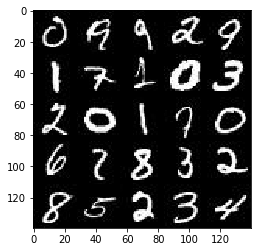

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

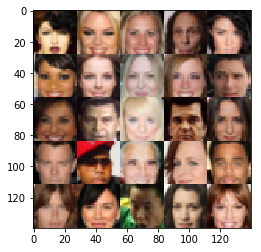

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :param alpha: Leaky ReLU factor (additionally added)
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):       
        # Image size is 28x28x3
        x1 = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=2, padding='same')
        x1 = tf.maximum(x1, x1 * alpha)
        
        # Image size is 14x14x64
        x2 = tf.layers.conv2d(x1, filters=128, kernel_size=5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2, x2 * alpha)
        
        # Image size is 8x8x128
        x3 = tf.layers.conv2d(x2, filters=256, kernel_size=5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3, x3 * alpha)
        
        flat = tf.reshape(x3, (-1, 8*8*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :param alpha: Leaky ReLU (added)
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512, activation=None) 
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(x1, x1 * alpha)
        # 7x7x256
        
        x2 = tf.layers.conv2d_transpose(x1, filters=256, kernel_size=5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(x2, x2 * alpha)
        # 14x14x256
        
        x3 = tf.layers.conv2d_transpose(x2, filters=128, kernel_size=5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(x3, x3 * alpha)
        # 28x28x128
        
        # Output layer 
        logits = tf.layers.conv2d_transpose(x3, filters=out_channel_dim, kernel_size=5, strides=1, padding='same')
        # 28 x 28 x outchannel_dim
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # TODO: Build Model with previous functions
    
    # Reset everything
    #tf.reset_default_graph()
    
    # Generate model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3]) #mimic input channels
    d_train_opt, g_train_opt= model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Verbose variable
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps +=1
                
                # Scale images
                batch_images *=2
                
                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run Optimizzzzzzzers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate}) # needs images?
                
                # Verbose output
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 50 == 0:
                    show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0003... Generator Loss: 9.2217
Epoch 1/2... Discriminator Loss: 0.0005... Generator Loss: 8.6814
Epoch 1/2... Discriminator Loss: 0.1434... Generator Loss: 4.6119
Epoch 1/2... Discriminator Loss: 0.2314... Generator Loss: 4.4238
Epoch 1/2... Discriminator Loss: 0.2103... Generator Loss: 2.4236


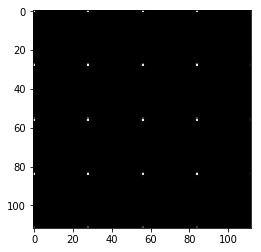

Epoch 1/2... Discriminator Loss: 0.0962... Generator Loss: 3.3174
Epoch 1/2... Discriminator Loss: 0.4010... Generator Loss: 2.0004
Epoch 1/2... Discriminator Loss: 0.2555... Generator Loss: 2.3760
Epoch 1/2... Discriminator Loss: 0.2307... Generator Loss: 2.5229
Epoch 1/2... Discriminator Loss: 1.2331... Generator Loss: 0.8214


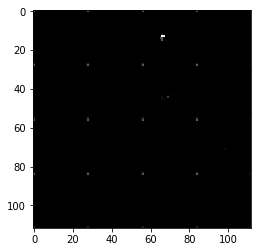

Epoch 1/2... Discriminator Loss: 0.8600... Generator Loss: 1.5832
Epoch 1/2... Discriminator Loss: 1.3825... Generator Loss: 2.9767
Epoch 1/2... Discriminator Loss: 0.9775... Generator Loss: 2.8653
Epoch 1/2... Discriminator Loss: 1.2461... Generator Loss: 1.9384
Epoch 1/2... Discriminator Loss: 0.6785... Generator Loss: 1.1590


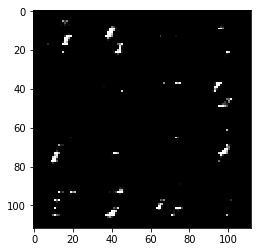

Epoch 1/2... Discriminator Loss: 0.8472... Generator Loss: 1.4748
Epoch 1/2... Discriminator Loss: 0.6228... Generator Loss: 3.1615
Epoch 1/2... Discriminator Loss: 1.0717... Generator Loss: 0.6268
Epoch 1/2... Discriminator Loss: 1.2377... Generator Loss: 0.4794
Epoch 1/2... Discriminator Loss: 0.4881... Generator Loss: 1.6879


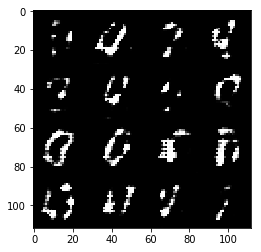

Epoch 1/2... Discriminator Loss: 0.6006... Generator Loss: 2.9215
Epoch 1/2... Discriminator Loss: 0.6294... Generator Loss: 2.0858
Epoch 1/2... Discriminator Loss: 2.7526... Generator Loss: 0.1016
Epoch 1/2... Discriminator Loss: 1.6577... Generator Loss: 0.3353
Epoch 1/2... Discriminator Loss: 1.5878... Generator Loss: 0.3504


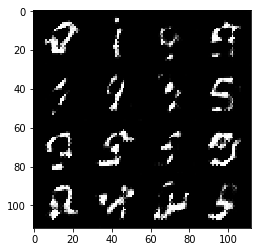

Epoch 1/2... Discriminator Loss: 0.4856... Generator Loss: 1.3051
Epoch 1/2... Discriminator Loss: 5.6863... Generator Loss: 9.3003
Epoch 1/2... Discriminator Loss: 0.6967... Generator Loss: 1.1572
Epoch 1/2... Discriminator Loss: 0.3212... Generator Loss: 2.1230
Epoch 1/2... Discriminator Loss: 0.1615... Generator Loss: 4.4173


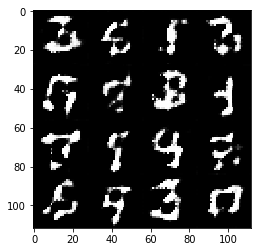

Epoch 1/2... Discriminator Loss: 0.4216... Generator Loss: 1.5568
Epoch 1/2... Discriminator Loss: 1.6563... Generator Loss: 3.4730
Epoch 1/2... Discriminator Loss: 0.8272... Generator Loss: 1.6974
Epoch 1/2... Discriminator Loss: 1.0722... Generator Loss: 2.8864
Epoch 1/2... Discriminator Loss: 0.7895... Generator Loss: 2.6679


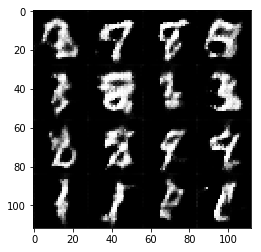

Epoch 1/2... Discriminator Loss: 0.3861... Generator Loss: 1.6393
Epoch 1/2... Discriminator Loss: 1.1001... Generator Loss: 0.5680
Epoch 1/2... Discriminator Loss: 0.4316... Generator Loss: 1.4668
Epoch 1/2... Discriminator Loss: 3.0427... Generator Loss: 4.4817
Epoch 1/2... Discriminator Loss: 0.9137... Generator Loss: 0.8480


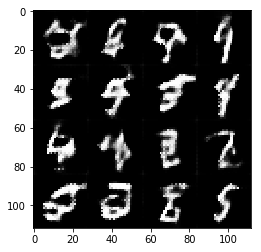

Epoch 1/2... Discriminator Loss: 1.2739... Generator Loss: 1.1993
Epoch 1/2... Discriminator Loss: 1.0825... Generator Loss: 1.6179
Epoch 1/2... Discriminator Loss: 0.9389... Generator Loss: 1.1538
Epoch 1/2... Discriminator Loss: 1.5026... Generator Loss: 0.3741
Epoch 1/2... Discriminator Loss: 1.4074... Generator Loss: 0.4804


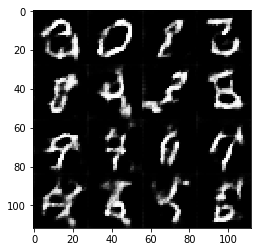

Epoch 1/2... Discriminator Loss: 0.8335... Generator Loss: 1.0452
Epoch 1/2... Discriminator Loss: 1.3154... Generator Loss: 2.1507
Epoch 1/2... Discriminator Loss: 0.7413... Generator Loss: 1.4743
Epoch 1/2... Discriminator Loss: 1.2806... Generator Loss: 1.6650
Epoch 1/2... Discriminator Loss: 1.0916... Generator Loss: 0.7532


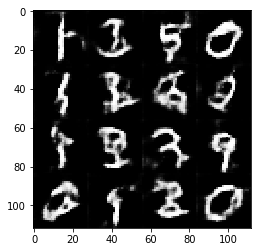

Epoch 1/2... Discriminator Loss: 1.4245... Generator Loss: 1.9527
Epoch 1/2... Discriminator Loss: 0.9399... Generator Loss: 1.5276
Epoch 1/2... Discriminator Loss: 0.9196... Generator Loss: 1.2837
Epoch 1/2... Discriminator Loss: 0.9030... Generator Loss: 1.0087
Epoch 1/2... Discriminator Loss: 0.8530... Generator Loss: 1.0557


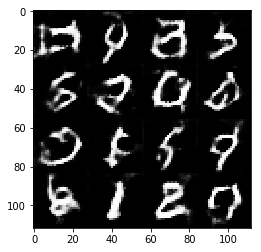

Epoch 1/2... Discriminator Loss: 1.2281... Generator Loss: 2.3789
Epoch 1/2... Discriminator Loss: 0.7621... Generator Loss: 1.1573
Epoch 1/2... Discriminator Loss: 1.3365... Generator Loss: 0.5138
Epoch 1/2... Discriminator Loss: 0.9439... Generator Loss: 1.0301
Epoch 1/2... Discriminator Loss: 1.3964... Generator Loss: 0.3710


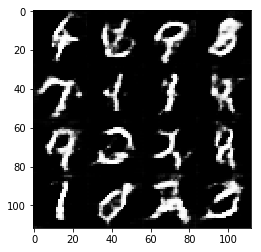

Epoch 1/2... Discriminator Loss: 0.9594... Generator Loss: 1.4392
Epoch 1/2... Discriminator Loss: 0.9742... Generator Loss: 0.9679
Epoch 1/2... Discriminator Loss: 1.0460... Generator Loss: 0.7054
Epoch 1/2... Discriminator Loss: 1.7157... Generator Loss: 3.0547
Epoch 1/2... Discriminator Loss: 1.4661... Generator Loss: 0.4444


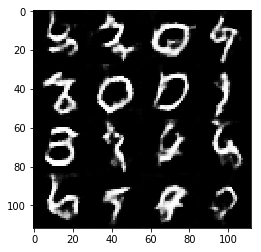

Epoch 1/2... Discriminator Loss: 1.0447... Generator Loss: 0.7006
Epoch 1/2... Discriminator Loss: 0.8908... Generator Loss: 1.2311
Epoch 1/2... Discriminator Loss: 1.2882... Generator Loss: 1.1786
Epoch 1/2... Discriminator Loss: 0.9773... Generator Loss: 1.3302
Epoch 1/2... Discriminator Loss: 1.1542... Generator Loss: 1.6164


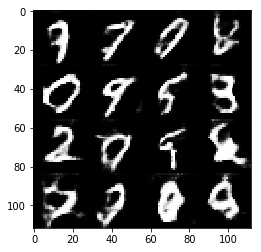

Epoch 1/2... Discriminator Loss: 1.1131... Generator Loss: 0.6465
Epoch 1/2... Discriminator Loss: 1.0689... Generator Loss: 0.7237
Epoch 1/2... Discriminator Loss: 1.0176... Generator Loss: 1.4326
Epoch 1/2... Discriminator Loss: 1.4196... Generator Loss: 0.6905
Epoch 1/2... Discriminator Loss: 1.2193... Generator Loss: 0.5113


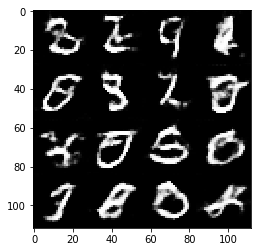

Epoch 1/2... Discriminator Loss: 1.0488... Generator Loss: 0.8185
Epoch 1/2... Discriminator Loss: 1.0483... Generator Loss: 0.9818
Epoch 1/2... Discriminator Loss: 1.1719... Generator Loss: 0.6797
Epoch 1/2... Discriminator Loss: 1.5318... Generator Loss: 0.3298
Epoch 1/2... Discriminator Loss: 1.0701... Generator Loss: 0.7360


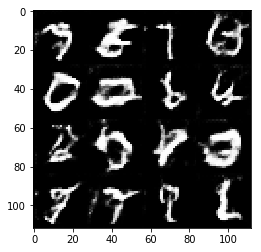

Epoch 1/2... Discriminator Loss: 1.1076... Generator Loss: 0.5841
Epoch 1/2... Discriminator Loss: 0.7724... Generator Loss: 1.5933
Epoch 1/2... Discriminator Loss: 1.0525... Generator Loss: 2.3472
Epoch 1/2... Discriminator Loss: 1.6800... Generator Loss: 0.3442
Epoch 1/2... Discriminator Loss: 1.4775... Generator Loss: 0.3877


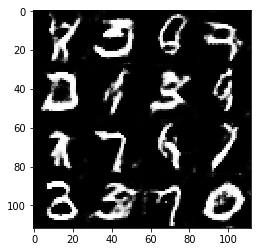

Epoch 1/2... Discriminator Loss: 1.4097... Generator Loss: 0.4067
Epoch 1/2... Discriminator Loss: 0.9992... Generator Loss: 1.6861
Epoch 1/2... Discriminator Loss: 0.9602... Generator Loss: 0.7690
Epoch 1/2... Discriminator Loss: 0.9950... Generator Loss: 1.3792
Epoch 1/2... Discriminator Loss: 0.9942... Generator Loss: 1.6357


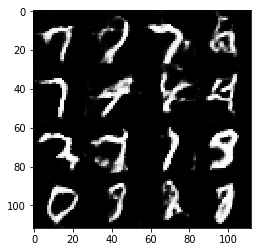

Epoch 1/2... Discriminator Loss: 1.2744... Generator Loss: 0.7221
Epoch 1/2... Discriminator Loss: 0.8934... Generator Loss: 0.9135
Epoch 1/2... Discriminator Loss: 1.0114... Generator Loss: 1.5837
Epoch 2/2... Discriminator Loss: 0.9562... Generator Loss: 0.8114
Epoch 2/2... Discriminator Loss: 1.2066... Generator Loss: 1.1140


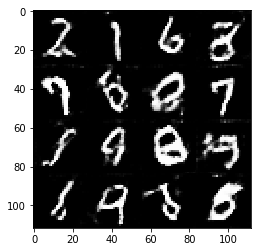

Epoch 2/2... Discriminator Loss: 1.2219... Generator Loss: 0.4661
Epoch 2/2... Discriminator Loss: 1.3860... Generator Loss: 0.4892
Epoch 2/2... Discriminator Loss: 1.0427... Generator Loss: 0.6690
Epoch 2/2... Discriminator Loss: 0.9252... Generator Loss: 1.2227
Epoch 2/2... Discriminator Loss: 1.1650... Generator Loss: 0.5236


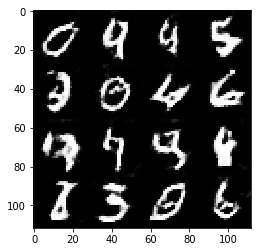

Epoch 2/2... Discriminator Loss: 0.7374... Generator Loss: 0.9943
Epoch 2/2... Discriminator Loss: 0.9877... Generator Loss: 1.0863
Epoch 2/2... Discriminator Loss: 1.3184... Generator Loss: 0.5140
Epoch 2/2... Discriminator Loss: 1.1869... Generator Loss: 0.6008
Epoch 2/2... Discriminator Loss: 1.0842... Generator Loss: 0.6413


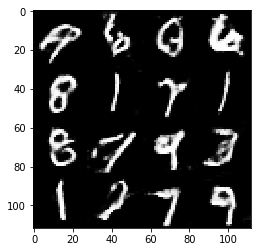

Epoch 2/2... Discriminator Loss: 1.1986... Generator Loss: 1.7218
Epoch 2/2... Discriminator Loss: 1.4475... Generator Loss: 0.3860
Epoch 2/2... Discriminator Loss: 0.9663... Generator Loss: 0.6798
Epoch 2/2... Discriminator Loss: 1.5384... Generator Loss: 0.3759
Epoch 2/2... Discriminator Loss: 1.5097... Generator Loss: 0.3448


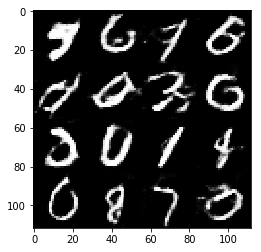

Epoch 2/2... Discriminator Loss: 1.0801... Generator Loss: 1.8774
Epoch 2/2... Discriminator Loss: 1.6360... Generator Loss: 2.1076
Epoch 2/2... Discriminator Loss: 0.9942... Generator Loss: 0.7787
Epoch 2/2... Discriminator Loss: 1.8518... Generator Loss: 0.2728
Epoch 2/2... Discriminator Loss: 0.9820... Generator Loss: 1.0145


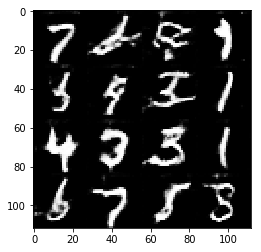

Epoch 2/2... Discriminator Loss: 1.0473... Generator Loss: 0.9817
Epoch 2/2... Discriminator Loss: 1.0845... Generator Loss: 1.5769
Epoch 2/2... Discriminator Loss: 1.3070... Generator Loss: 0.5399
Epoch 2/2... Discriminator Loss: 1.2494... Generator Loss: 0.6703
Epoch 2/2... Discriminator Loss: 2.1575... Generator Loss: 0.2147


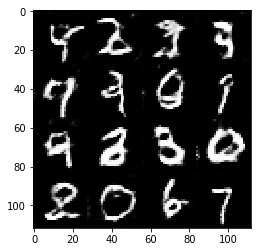

Epoch 2/2... Discriminator Loss: 1.2060... Generator Loss: 0.6135
Epoch 2/2... Discriminator Loss: 1.5659... Generator Loss: 0.4444
Epoch 2/2... Discriminator Loss: 1.0345... Generator Loss: 0.6834
Epoch 2/2... Discriminator Loss: 1.0520... Generator Loss: 1.2141
Epoch 2/2... Discriminator Loss: 1.0379... Generator Loss: 0.8419


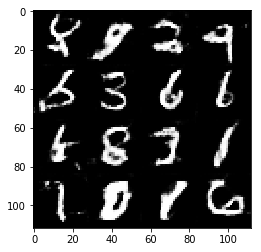

Epoch 2/2... Discriminator Loss: 1.1007... Generator Loss: 1.9552
Epoch 2/2... Discriminator Loss: 1.0958... Generator Loss: 1.8137
Epoch 2/2... Discriminator Loss: 1.8733... Generator Loss: 0.2105
Epoch 2/2... Discriminator Loss: 0.7364... Generator Loss: 1.0993
Epoch 2/2... Discriminator Loss: 0.4463... Generator Loss: 1.8441


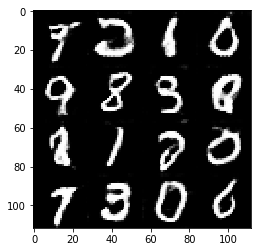

Epoch 2/2... Discriminator Loss: 1.5506... Generator Loss: 0.4589
Epoch 2/2... Discriminator Loss: 1.1295... Generator Loss: 0.7060
Epoch 2/2... Discriminator Loss: 0.9097... Generator Loss: 1.1759
Epoch 2/2... Discriminator Loss: 1.2952... Generator Loss: 0.4570
Epoch 2/2... Discriminator Loss: 0.9019... Generator Loss: 0.9865


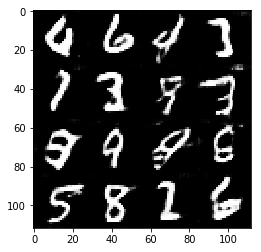

Epoch 2/2... Discriminator Loss: 1.0822... Generator Loss: 0.7611
Epoch 2/2... Discriminator Loss: 0.9189... Generator Loss: 0.9769
Epoch 2/2... Discriminator Loss: 1.1589... Generator Loss: 0.5993
Epoch 2/2... Discriminator Loss: 1.1902... Generator Loss: 0.5807
Epoch 2/2... Discriminator Loss: 0.9066... Generator Loss: 1.0622


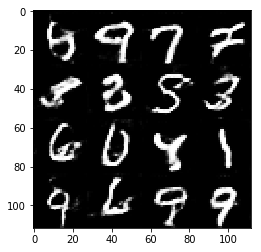

Epoch 2/2... Discriminator Loss: 1.1662... Generator Loss: 0.5986
Epoch 2/2... Discriminator Loss: 1.0923... Generator Loss: 0.6858
Epoch 2/2... Discriminator Loss: 0.8936... Generator Loss: 1.1656
Epoch 2/2... Discriminator Loss: 1.0871... Generator Loss: 1.3125
Epoch 2/2... Discriminator Loss: 0.9959... Generator Loss: 1.0821


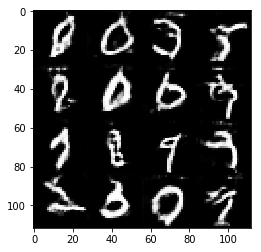

Epoch 2/2... Discriminator Loss: 0.9028... Generator Loss: 0.8209
Epoch 2/2... Discriminator Loss: 0.8921... Generator Loss: 0.9585
Epoch 2/2... Discriminator Loss: 0.8503... Generator Loss: 1.0199
Epoch 2/2... Discriminator Loss: 0.8599... Generator Loss: 2.0664
Epoch 2/2... Discriminator Loss: 1.9142... Generator Loss: 3.1335


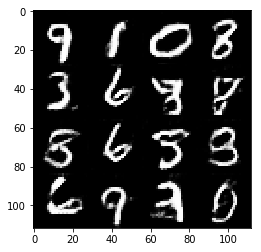

Epoch 2/2... Discriminator Loss: 1.7173... Generator Loss: 0.3237
Epoch 2/2... Discriminator Loss: 0.9573... Generator Loss: 1.0406
Epoch 2/2... Discriminator Loss: 0.8857... Generator Loss: 0.8572
Epoch 2/2... Discriminator Loss: 1.3997... Generator Loss: 1.8591
Epoch 2/2... Discriminator Loss: 1.4769... Generator Loss: 0.4171


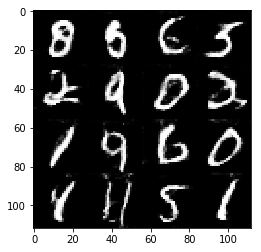

Epoch 2/2... Discriminator Loss: 1.0302... Generator Loss: 0.8022
Epoch 2/2... Discriminator Loss: 0.9937... Generator Loss: 1.9087
Epoch 2/2... Discriminator Loss: 0.7240... Generator Loss: 1.2990
Epoch 2/2... Discriminator Loss: 0.8413... Generator Loss: 0.9377
Epoch 2/2... Discriminator Loss: 0.7568... Generator Loss: 1.0361


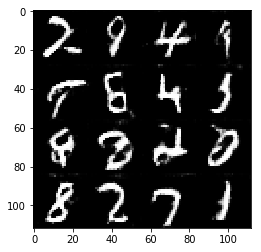

Epoch 2/2... Discriminator Loss: 1.0384... Generator Loss: 0.5923
Epoch 2/2... Discriminator Loss: 1.0350... Generator Loss: 0.8555
Epoch 2/2... Discriminator Loss: 0.7132... Generator Loss: 1.0846
Epoch 2/2... Discriminator Loss: 2.0742... Generator Loss: 0.1902
Epoch 2/2... Discriminator Loss: 0.8633... Generator Loss: 1.5171


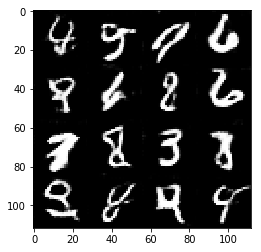

Epoch 2/2... Discriminator Loss: 1.2389... Generator Loss: 1.0698
Epoch 2/2... Discriminator Loss: 1.1607... Generator Loss: 0.5935
Epoch 2/2... Discriminator Loss: 1.4423... Generator Loss: 2.6391
Epoch 2/2... Discriminator Loss: 0.8356... Generator Loss: 1.9283
Epoch 2/2... Discriminator Loss: 0.8252... Generator Loss: 1.0519


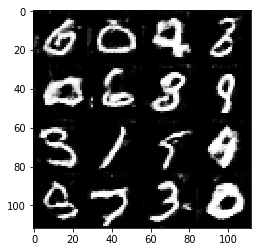

Epoch 2/2... Discriminator Loss: 0.6640... Generator Loss: 1.5580
Epoch 2/2... Discriminator Loss: 0.6429... Generator Loss: 2.0643
Epoch 2/2... Discriminator Loss: 1.8022... Generator Loss: 0.3024
Epoch 2/2... Discriminator Loss: 1.6993... Generator Loss: 0.2772
Epoch 2/2... Discriminator Loss: 1.2813... Generator Loss: 0.4333


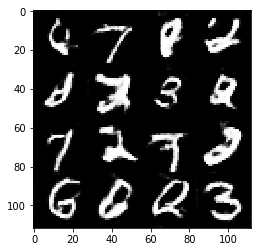

Epoch 2/2... Discriminator Loss: 0.8431... Generator Loss: 1.0932
Epoch 2/2... Discriminator Loss: 0.8218... Generator Loss: 1.9432
Epoch 2/2... Discriminator Loss: 0.7139... Generator Loss: 1.2929
Epoch 2/2... Discriminator Loss: 1.3409... Generator Loss: 0.5471
Epoch 2/2... Discriminator Loss: 1.4699... Generator Loss: 0.4183


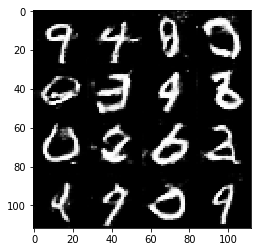

Epoch 2/2... Discriminator Loss: 1.0527... Generator Loss: 1.0311
Epoch 2/2... Discriminator Loss: 0.9303... Generator Loss: 0.9239
Epoch 2/2... Discriminator Loss: 0.7262... Generator Loss: 1.0686
Epoch 2/2... Discriminator Loss: 0.5426... Generator Loss: 1.2629
Epoch 2/2... Discriminator Loss: 1.3438... Generator Loss: 2.7268


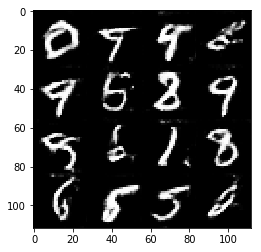

Epoch 2/2... Discriminator Loss: 0.9477... Generator Loss: 2.6331
Epoch 2/2... Discriminator Loss: 1.1876... Generator Loss: 0.6566


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.1806... Generator Loss: 20.1057
Epoch 1/1... Discriminator Loss: 0.0021... Generator Loss: 7.1220
Epoch 1/1... Discriminator Loss: 0.1760... Generator Loss: 2.9240
Epoch 1/1... Discriminator Loss: 0.6400... Generator Loss: 1.2965
Epoch 1/1... Discriminator Loss: 1.0205... Generator Loss: 0.7981


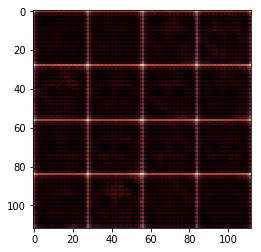

Epoch 1/1... Discriminator Loss: 0.6461... Generator Loss: 1.3035
Epoch 1/1... Discriminator Loss: 0.8758... Generator Loss: 0.8551
Epoch 1/1... Discriminator Loss: 0.6420... Generator Loss: 1.3338
Epoch 1/1... Discriminator Loss: 0.0199... Generator Loss: 9.9348
Epoch 1/1... Discriminator Loss: 0.1811... Generator Loss: 4.6349


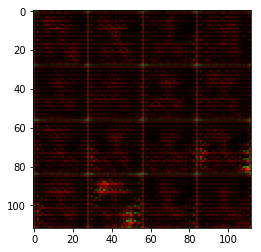

Epoch 1/1... Discriminator Loss: 0.0845... Generator Loss: 3.7085
Epoch 1/1... Discriminator Loss: 0.2669... Generator Loss: 2.4581
Epoch 1/1... Discriminator Loss: 0.1434... Generator Loss: 4.9449
Epoch 1/1... Discriminator Loss: 1.8836... Generator Loss: 6.0855
Epoch 1/1... Discriminator Loss: 0.4994... Generator Loss: 1.3667


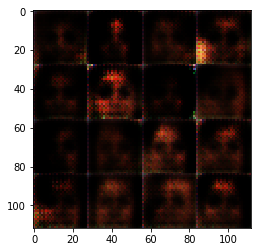

Epoch 1/1... Discriminator Loss: 2.4160... Generator Loss: 0.3855
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 5.5229
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 1.1086
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.4731


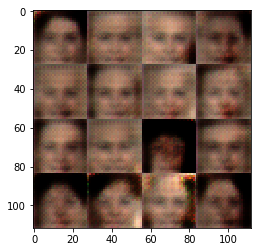

Epoch 1/1... Discriminator Loss: 1.0404... Generator Loss: 1.9237
Epoch 1/1... Discriminator Loss: 0.9168... Generator Loss: 1.6249
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 0.8853
Epoch 1/1... Discriminator Loss: 1.6270... Generator Loss: 0.3126
Epoch 1/1... Discriminator Loss: 1.7874... Generator Loss: 0.3644


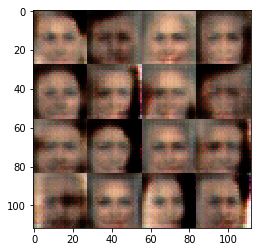

Epoch 1/1... Discriminator Loss: 0.6126... Generator Loss: 1.8281
Epoch 1/1... Discriminator Loss: 0.6973... Generator Loss: 1.5526
Epoch 1/1... Discriminator Loss: 0.6950... Generator Loss: 1.0606
Epoch 1/1... Discriminator Loss: 0.8968... Generator Loss: 1.0302
Epoch 1/1... Discriminator Loss: 1.6326... Generator Loss: 0.3477


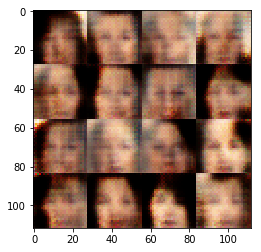

Epoch 1/1... Discriminator Loss: 1.7742... Generator Loss: 0.3203
Epoch 1/1... Discriminator Loss: 2.6642... Generator Loss: 0.1053
Epoch 1/1... Discriminator Loss: 1.2213... Generator Loss: 2.4122
Epoch 1/1... Discriminator Loss: 1.6560... Generator Loss: 1.6548
Epoch 1/1... Discriminator Loss: 1.1393... Generator Loss: 2.3715


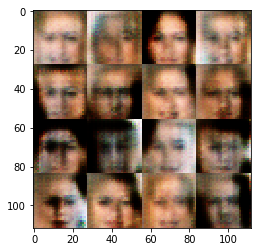

Epoch 1/1... Discriminator Loss: 1.5412... Generator Loss: 1.1993
Epoch 1/1... Discriminator Loss: 1.1144... Generator Loss: 1.0100
Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 0.4959
Epoch 1/1... Discriminator Loss: 1.6105... Generator Loss: 1.4492
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 2.0030


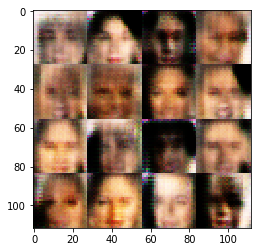

Epoch 1/1... Discriminator Loss: 0.5185... Generator Loss: 1.3297
Epoch 1/1... Discriminator Loss: 1.8160... Generator Loss: 0.2320
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.4982
Epoch 1/1... Discriminator Loss: 0.8415... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 0.4117


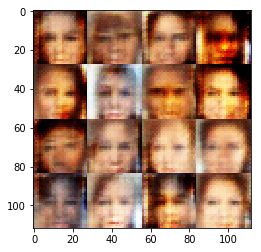

Epoch 1/1... Discriminator Loss: 1.9260... Generator Loss: 0.2191
Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 0.5477
Epoch 1/1... Discriminator Loss: 0.9033... Generator Loss: 1.0096
Epoch 1/1... Discriminator Loss: 0.8135... Generator Loss: 1.2338
Epoch 1/1... Discriminator Loss: 2.2909... Generator Loss: 0.1332


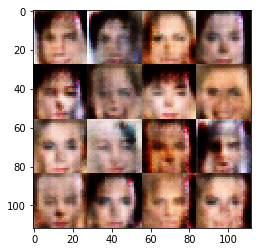

Epoch 1/1... Discriminator Loss: 0.8137... Generator Loss: 1.1390
Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.8016... Generator Loss: 1.8553
Epoch 1/1... Discriminator Loss: 2.0097... Generator Loss: 2.5253
Epoch 1/1... Discriminator Loss: 1.6732... Generator Loss: 1.5432


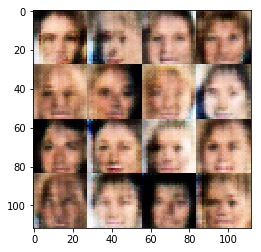

Epoch 1/1... Discriminator Loss: 0.7188... Generator Loss: 1.3499
Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 0.3939
Epoch 1/1... Discriminator Loss: 1.1954... Generator Loss: 1.4262
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 0.9914
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 0.8539


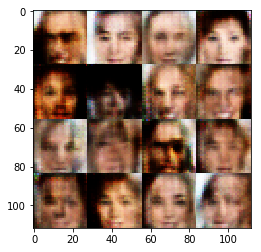

Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.9641
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.9091
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 1.3959
Epoch 1/1... Discriminator Loss: 1.0410... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 2.2310


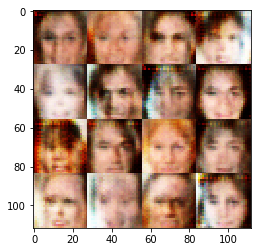

Epoch 1/1... Discriminator Loss: 1.5177... Generator Loss: 0.5140
Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 1.2890
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.3677
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 0.7125
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 1.4327


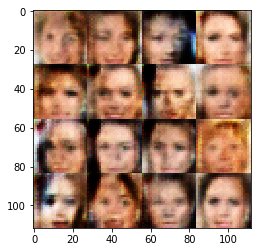

Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 1.5384
Epoch 1/1... Discriminator Loss: 1.1750... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 0.6663... Generator Loss: 1.6483
Epoch 1/1... Discriminator Loss: 0.9385... Generator Loss: 1.1779
Epoch 1/1... Discriminator Loss: 0.9159... Generator Loss: 1.1375


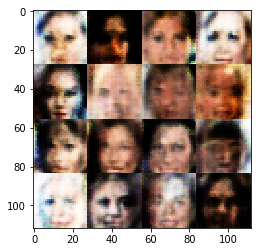

Epoch 1/1... Discriminator Loss: 1.1979... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 0.8422... Generator Loss: 4.2645
Epoch 1/1... Discriminator Loss: 1.5570... Generator Loss: 0.3324
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 1.1920


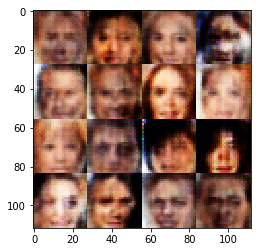

Epoch 1/1... Discriminator Loss: 0.9197... Generator Loss: 0.9144
Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 1.8498
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.4504
Epoch 1/1... Discriminator Loss: 0.9823... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 2.4280... Generator Loss: 0.1133


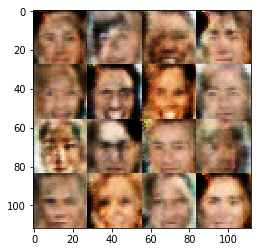

Epoch 1/1... Discriminator Loss: 1.2334... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.5688... Generator Loss: 0.3057
Epoch 1/1... Discriminator Loss: 0.8638... Generator Loss: 0.7442
Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 1.0857


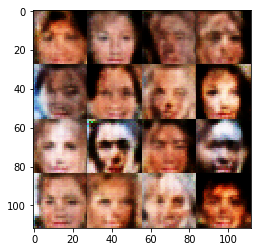

Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 0.6313... Generator Loss: 1.4561
Epoch 1/1... Discriminator Loss: 0.8410... Generator Loss: 1.6069
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.4300


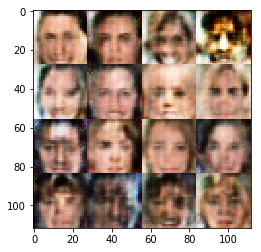

Epoch 1/1... Discriminator Loss: 0.5652... Generator Loss: 1.6628
Epoch 1/1... Discriminator Loss: 0.9305... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.0614... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 0.8947... Generator Loss: 1.9544
Epoch 1/1... Discriminator Loss: 1.0436... Generator Loss: 0.9411


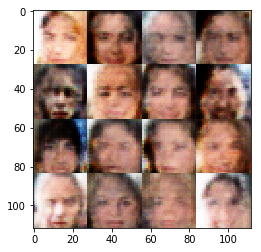

Epoch 1/1... Discriminator Loss: 1.7303... Generator Loss: 0.2929
Epoch 1/1... Discriminator Loss: 1.7469... Generator Loss: 0.3921
Epoch 1/1... Discriminator Loss: 1.7715... Generator Loss: 0.2156
Epoch 1/1... Discriminator Loss: 0.8708... Generator Loss: 1.0331
Epoch 1/1... Discriminator Loss: 1.0355... Generator Loss: 1.7413


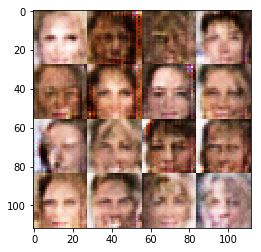

Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 0.6633
Epoch 1/1... Discriminator Loss: 2.1341... Generator Loss: 0.1782
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 1.0835
Epoch 1/1... Discriminator Loss: 1.6911... Generator Loss: 0.3579
Epoch 1/1... Discriminator Loss: 1.1649... Generator Loss: 0.7552


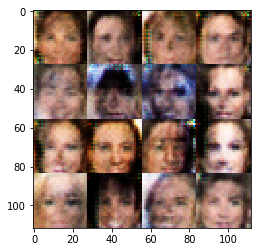

Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 0.9284
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 1.0471... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.5993


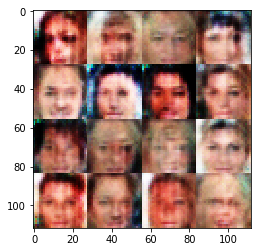

Epoch 1/1... Discriminator Loss: 1.5707... Generator Loss: 0.3221
Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 1.0652
Epoch 1/1... Discriminator Loss: 1.0268... Generator Loss: 1.1908
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.8765
Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 0.5798


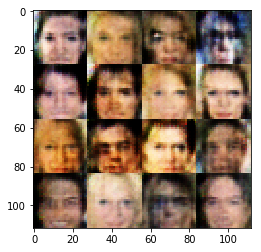

Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.5621
Epoch 1/1... Discriminator Loss: 1.5891... Generator Loss: 0.4608
Epoch 1/1... Discriminator Loss: 1.2539... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.4908... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 0.6705


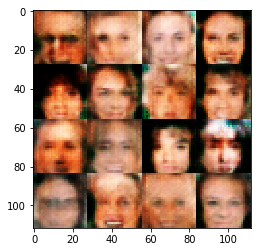

Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.5554
Epoch 1/1... Discriminator Loss: 1.1341... Generator Loss: 2.2494
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 1.6805... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 0.5990


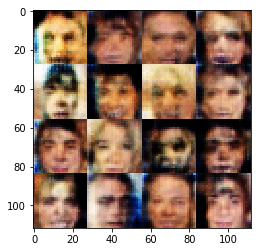

Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.0532... Generator Loss: 1.0536
Epoch 1/1... Discriminator Loss: 1.5481... Generator Loss: 0.3896
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 1.3457
Epoch 1/1... Discriminator Loss: 1.4823... Generator Loss: 1.7653


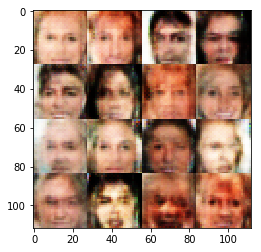

Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 1.0686
Epoch 1/1... Discriminator Loss: 1.0448... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.1536... Generator Loss: 0.6072
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.3698
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.9407


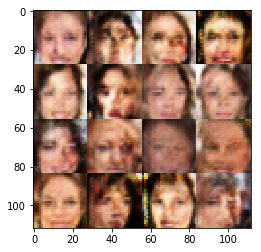

Epoch 1/1... Discriminator Loss: 1.2495... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.1806... Generator Loss: 0.9127
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.3446
Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 1.3359
Epoch 1/1... Discriminator Loss: 2.5025... Generator Loss: 2.3424


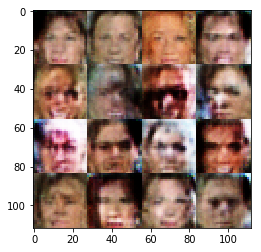

Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.6291
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.7243
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.7290
Epoch 1/1... Discriminator Loss: 0.9109... Generator Loss: 1.3155
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 0.7080


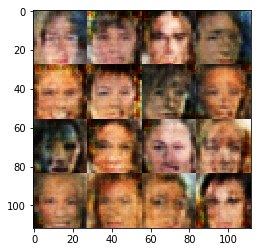

Epoch 1/1... Discriminator Loss: 1.5259... Generator Loss: 1.1176
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.6048... Generator Loss: 1.2982
Epoch 1/1... Discriminator Loss: 0.9107... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 1.4971... Generator Loss: 0.5258


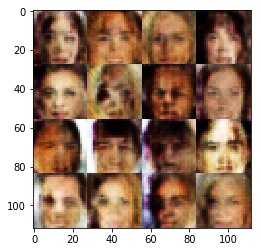

Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.5542
Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 0.6262
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.5329
Epoch 1/1... Discriminator Loss: 0.8171... Generator Loss: 2.0551
Epoch 1/1... Discriminator Loss: 1.5597... Generator Loss: 1.2442


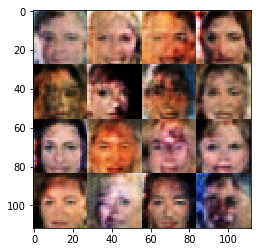

Epoch 1/1... Discriminator Loss: 1.5261... Generator Loss: 0.5072
Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 1.0000
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 0.5217
Epoch 1/1... Discriminator Loss: 1.4844... Generator Loss: 1.1926


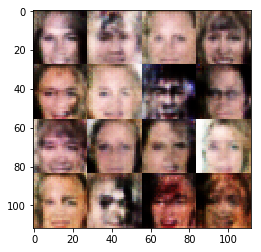

Epoch 1/1... Discriminator Loss: 0.9619... Generator Loss: 0.8660
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 1.4681
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 0.8335
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 0.5251


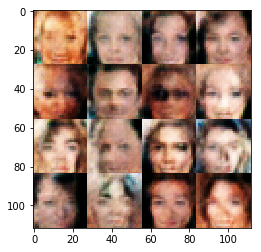

Epoch 1/1... Discriminator Loss: 1.8617... Generator Loss: 0.2095
Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.5571
Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 0.9562
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.5470


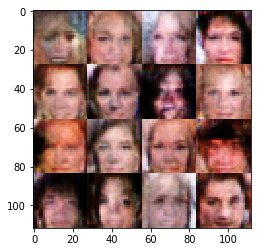

Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 1.3103
Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.4110
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.5630


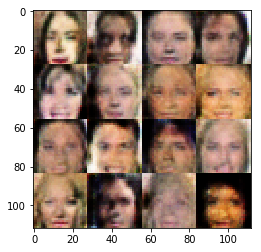

Epoch 1/1... Discriminator Loss: 0.7581... Generator Loss: 1.1308
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 1.3707
Epoch 1/1... Discriminator Loss: 1.5097... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 1.5733... Generator Loss: 0.3850
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.6381


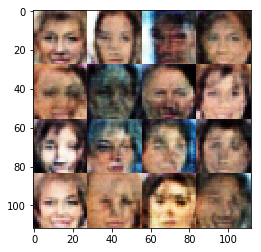

Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 1.0396
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 0.5401
Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 0.4339
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.6196
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.5466


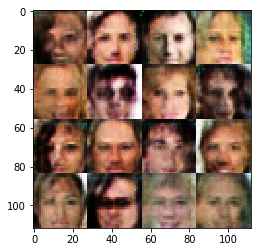

Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 0.5835
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.5038
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.7546


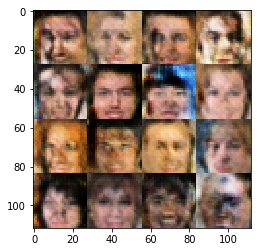

Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 0.5839
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 1.0097
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.5490
Epoch 1/1... Discriminator Loss: 2.1253... Generator Loss: 0.1642
Epoch 1/1... Discriminator Loss: 1.6590... Generator Loss: 0.2945


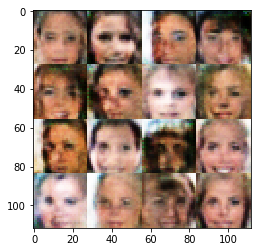

Epoch 1/1... Discriminator Loss: 1.0829... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.2273... Generator Loss: 0.6166
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 1.0198
Epoch 1/1... Discriminator Loss: 1.2384... Generator Loss: 0.7818


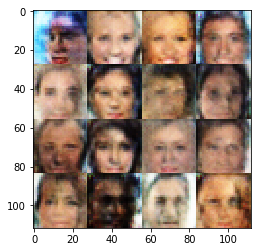

Epoch 1/1... Discriminator Loss: 1.1168... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.9160
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 1.0195
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.6299
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.7413


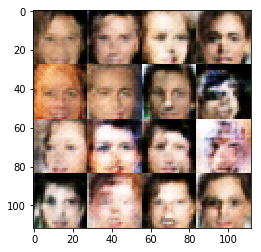

Epoch 1/1... Discriminator Loss: 1.6333... Generator Loss: 0.4212
Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 0.5728
Epoch 1/1... Discriminator Loss: 0.8372... Generator Loss: 1.0057
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 0.8988
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.4389


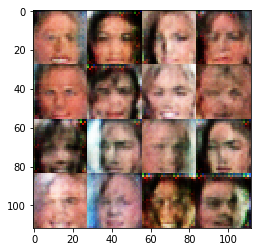

Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.5462
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 0.6417
Epoch 1/1... Discriminator Loss: 1.1722... Generator Loss: 1.5268


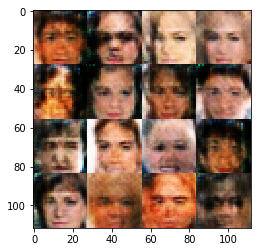

Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 0.8854
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 1.7102
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.5975
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.8163


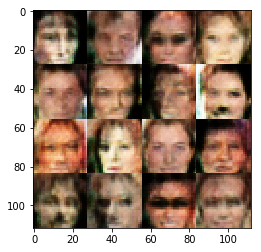

Epoch 1/1... Discriminator Loss: 1.2098... Generator Loss: 0.5800
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.1491... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 1.0013
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.6175


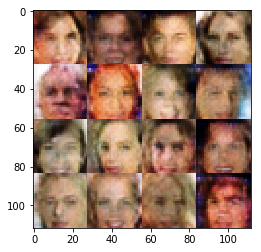

Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.2148... Generator Loss: 0.6050
Epoch 1/1... Discriminator Loss: 1.1043... Generator Loss: 0.9020
Epoch 1/1... Discriminator Loss: 1.6070... Generator Loss: 0.3705
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 1.0902


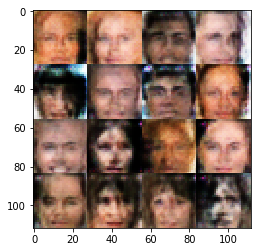

Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 1.7212
Epoch 1/1... Discriminator Loss: 1.7190... Generator Loss: 0.2439
Epoch 1/1... Discriminator Loss: 1.4742... Generator Loss: 0.5902
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.6370
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.4302


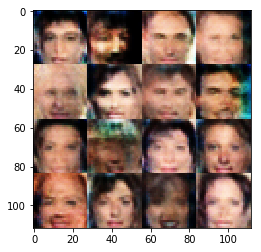

Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.5108
Epoch 1/1... Discriminator Loss: 0.9735... Generator Loss: 1.0727
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.5205
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 0.7811


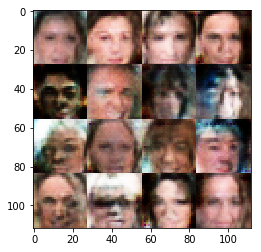

Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.5093
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.5839
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.0201... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.0936... Generator Loss: 0.7145


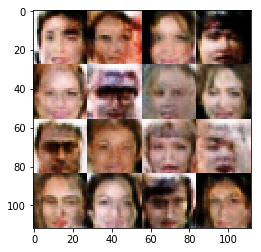

Epoch 1/1... Discriminator Loss: 1.0934... Generator Loss: 1.0281
Epoch 1/1... Discriminator Loss: 1.7739... Generator Loss: 0.8991
Epoch 1/1... Discriminator Loss: 1.0771... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 1.7257... Generator Loss: 1.0963


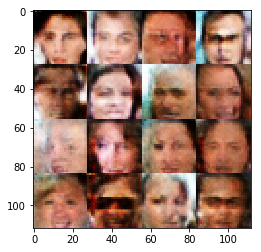

Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.5282
Epoch 1/1... Discriminator Loss: 0.8408... Generator Loss: 1.3993
Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.4888
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.4567
Epoch 1/1... Discriminator Loss: 1.2013... Generator Loss: 0.6219


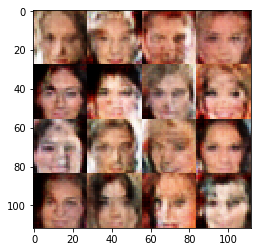

Epoch 1/1... Discriminator Loss: 1.9651... Generator Loss: 0.1859
Epoch 1/1... Discriminator Loss: 1.2551... Generator Loss: 0.6415
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 0.9218
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 1.0138


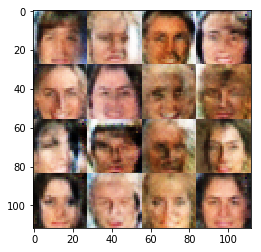

Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.4935
Epoch 1/1... Discriminator Loss: 1.7575... Generator Loss: 0.2650
Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 1.2975
Epoch 1/1... Discriminator Loss: 1.5668... Generator Loss: 0.3705


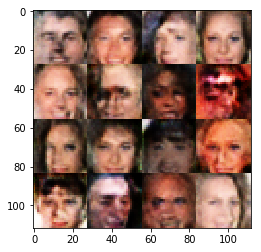

Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.0915... Generator Loss: 1.2205
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 0.8789
Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.4357


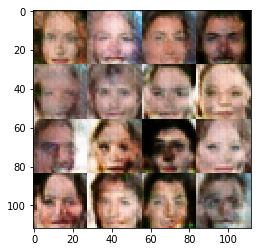

Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 1.8387... Generator Loss: 0.2135
Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 0.9715
Epoch 1/1... Discriminator Loss: 0.7062... Generator Loss: 1.5185
Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 0.7272


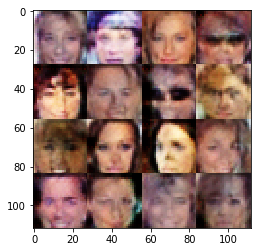

Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 1.3929
Epoch 1/1... Discriminator Loss: 1.6409... Generator Loss: 0.3002
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 0.4995
Epoch 1/1... Discriminator Loss: 1.0214... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 0.6594


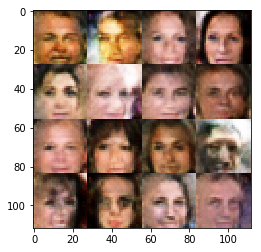

Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 0.5959
Epoch 1/1... Discriminator Loss: 1.8137... Generator Loss: 2.1369
Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 0.6036
Epoch 1/1... Discriminator Loss: 1.1826... Generator Loss: 1.0715
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 1.2625


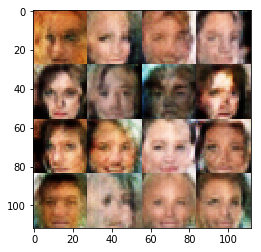

Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.9271
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.5703
Epoch 1/1... Discriminator Loss: 0.9690... Generator Loss: 1.1075
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.5861


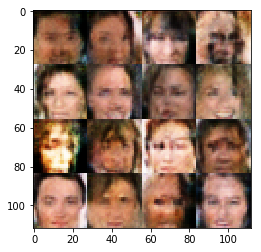

Epoch 1/1... Discriminator Loss: 1.2625... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.0851... Generator Loss: 0.5919
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.4860... Generator Loss: 0.4436


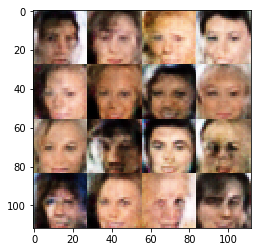

Epoch 1/1... Discriminator Loss: 1.5848... Generator Loss: 0.3078
Epoch 1/1... Discriminator Loss: 1.5722... Generator Loss: 0.3503
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.6275
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.4935


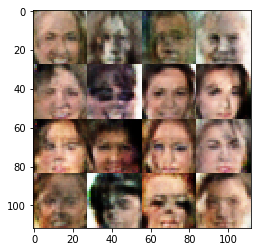

Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 1.1781
Epoch 1/1... Discriminator Loss: 1.0289... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 0.8725
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.5344
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.5559


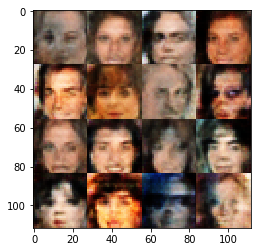

Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 0.9230
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.4349
Epoch 1/1... Discriminator Loss: 1.8281... Generator Loss: 0.3434
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.5041


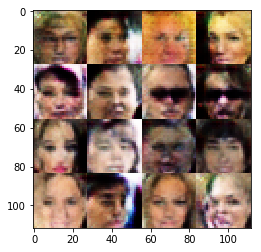

Epoch 1/1... Discriminator Loss: 1.0860... Generator Loss: 1.4449


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.